## Generate word2vec skip-gram embeddings using TensorFlow

Using Noise Contrastive Estimator (NCE) as a loss function instead of Softmax.

Modified from original code here: http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/

## Word2Vec
The Word2Vec Methodology is two-fold - first is the mapping of a high dimensional one-hot style representation of words to a lower dimensional vector, second is to preserve contextual meaning. It is a prediction based word embedding which learns dense vector representations of words capturing semantic meaning. 
"Queen" = "King" + "Woman" - "Man"

Similarity of words is well-captured by cosine similarity of its vectors - we'd except synonyms to have high cosine similarity. There are two main word2vec models: Continuous Bag of Words (CBOW) and Skip-Gram. In the CBOW model, we predict a word given a context (a context can be something like a sentence). Skip-Gram is the opposite: predict the context given an input word.
### Skip-gram Model 
In Skip-Gram we predict the context C given and input word (eg:"cat"), where is in CBOW we predict the word from C. The training objective of the Skip-Gram model is to learn word vector representations that are good at predicting nearby words in the associated context. V is vocabulary size and the hyperparameter N is the dimension of the hidden layer (embedding size). The weights between the input layer and the hidden layer is represented by $V\times N$ matrix $\textbf{W}$, $V = 100,000$ & $N = 50$

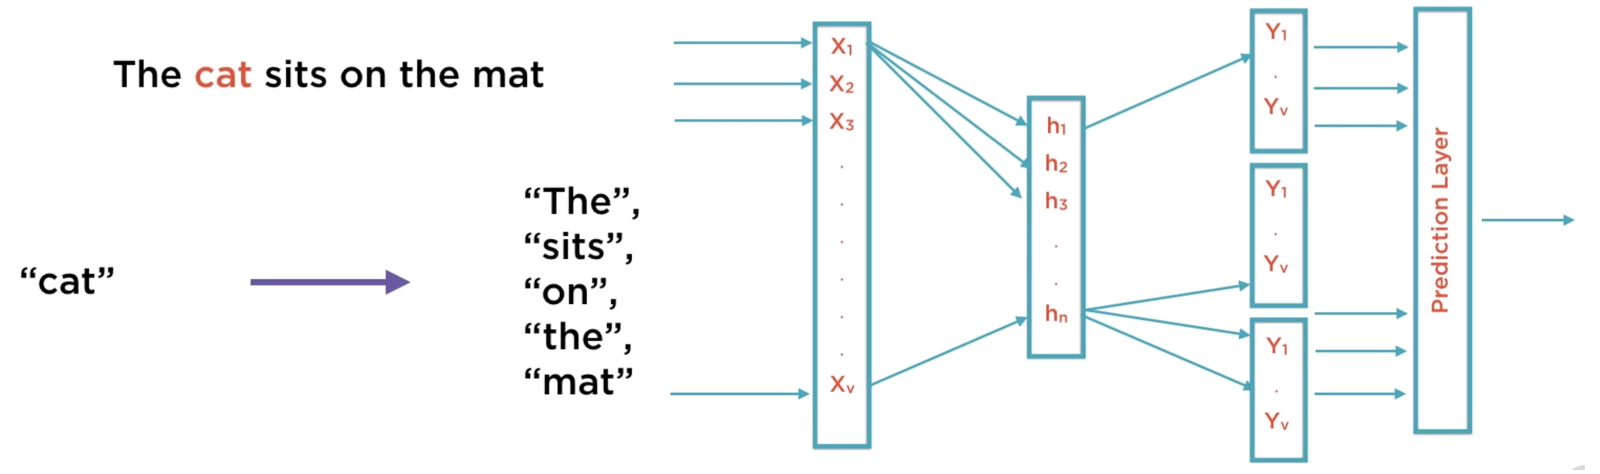


## Noise Contrasive Estimator (NCE) - better measure of loss

The Softmax Prediction is computionally expensive - our output layer with dimension equal to our vocabulary size is sent to the Softmax Predictor which computes a probability for each word in our vocabulary. 

The predictor computes the maximum likelihood estimate of $W_{1}$, $W_{2}$,.. $W_{t-1}$, $W_{t+1}$, $W_{t+2}$,..., $W_{t+n}$ that maximises this probability $P(W_1, W_2, ..., W_{t-1} \& W_{t+1}, W_{t+2},..., W_{t+n}|W_t)$. 

This computation quickly descends to a parameter explosion. Take for example a vocabulary size of 10,000 words(V dim of output layer in the skip-gram model) and 300 embeddings (N dim of hidden layer) - this leads to 3 million weights (N x V). 

NCE is a **candidate sampling technique** that reduces the computation required
> * Do not consider all the possible context words
> * Use random sample (<100)
> * Evaluate probability from this random sample
> * performs 100x speedup 

In order to implement this we use NCE as the loss function for our gradient descent optimiser. *tf.nce_loss*

**How does this work?**

A "standard" neural network is usually trained with a cross-entropy cost function which requires the values of the output neurons to represent probabilities - which means that the output "scores" computed by the network for each class have to be normalized, converted into actual probabilities for each class. This **normalization** step is achieved by means of the **softmax** function. Softmax is very costly when applied to a huge output layer.

The basic idea is to convert a multinomial classification problem (as it is the problem of predicting the relevant context words) to a binary classification problem. Instead of using softmax to estimate the true probability distribution of the output word, a **binary logistic regression** (binary classification) is used instead.

For each training sample, the enhanced (optimized) classifier is fed a true pair (a center word and another word that appears in its context) and a number of KK randomly corrupted pairs (consisting of the center word and a randomly chosen word from the vocabulary). By learning to **distinguish the true pairs from corrupted ones**, the classifier will ultimately learn the word vectors. It is crucial to note that instead of predicting the relevant context words to the input word (the "standard" training technique), the **optimized classifier simply predicts whether a pair of words is good or bad**.


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import zipfile

In [3]:
from six.moves import urllib
from six.moves import xrange

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
DOWNLOADED_FILENAME = 'SampleText.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)

    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)

        raise Exception(
            'Failed to verify file from: ' + url_path + '. Can you get to it with a browser?')

In [6]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    
    return words

In [7]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


#### Get the list of words from the the sample, this is our entire vocabulary

In [8]:
vocabulary = read_words()

In [9]:
len(vocabulary)

17005207

In [10]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

### Build the data set used to generate word2vec embeddings

* *words* A list of all words in the input dataset
* *n_words* The number of words to include in the dataset. We use the most frequently occurring n_words

Return values are:

* *word_counts* The most frequently occurring words and the corresponding frequencies
> we only intend to create word embeddings for the 10 most frequent words - therefore all the rest are added to 'UNKNOWN'
* *word_indexes* The list of index values which uniquely identifies each word in the dataset
* *dictionary* Mapping from a word to its unique index
* *reversed_dictionary* Mapping from the unique index to the word

In [11]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
    #adds the most common words to the word_counts array
 
    # Only the most common words are added to the dictionary
    dictionary = dict()
    
    for word, _ in word_counts:
        # The current length of the dictionary is the unique index of this word
        # added to the dictionary
        dictionary[word] = len(dictionary)
    
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNKNOWN']
            unknown_count += 1
        
        word_indexes.append(index)
    
    # Count of unknown words
    word_counts[0][1] = unknown_count
    
    # Map from unique indexes to word
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return  word_counts, word_indexes, dictionary, reversed_dictionary

In [12]:
VOCABULARY_SIZE = 100000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [13]:
word_counts[:10]

[['UNKNOWN', 189230],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [14]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [15]:
for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])

syndicalism : 24624
mombasa : 37510
forastero : 62234
hauck : 54895
pregnant : 7396
champions : 5109
tame : 21845
morrigan : 57138
valuation : 19111
suspensor : 82084


In [16]:
for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

28409 : tempted
77331 : gompers
19924 : nauru
37170 : cmyk
72821 : controversialist
65617 : phillipson
48383 : beyer
95968 : btrieve
64939 : avenches
97068 : kansans


#### A hint to the Python interpreter that vocabulary can be deleted

In [17]:
del vocabulary

### Return one batch of data and the corresponding labels for training

* *word_indexes* A list of unique indexes which identifies each word in the dataset. The most popular words have the lowest index values
* *batch_size* The number of elements in each batch
* *num_skips* The number of words to choose from the neighboring words within the skip_window. Each input word will appear num_skips times in the batch with a context or neighboring word as the corresponding label
* *skip_window* How many words to consider around one input word

In [18]:
# Global index into words maintained across batches
global_index = 0

def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index

    # For every input we find num_skips context words within a window
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # batch = [1, 2, 3, .... batch_size]
    # labels = [[1], [2], [3], ..., [batch_size]]
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The span of a window includes the skip_window elements on each side
    # of the input word plus the word itself
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]

    # A deque is double-ended queue which supports memory efficient appends
    # and pops from each side
    buffer = collections.deque(maxlen=span)

    # Initialize the deque with the first words in the deque
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]

        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            labels[i * num_skips + j, 0] = buffer[target]  # these are the context words
        
        # The first word from the buffer is removed automatically when a new word
        # is added in at the end
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    # Backtrack a little bit to avoid skipping words in the end of a batch, these
    # words will be captured in the next batch
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)

    return batch, labels

In [19]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [20]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156],
      dtype=int32)

In [21]:
# labels

In [22]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]])

of :  term
of :  abuse
abuse :  used
abuse :  a
first :  class
first :  used
used :  abuse
used :  first
against :  including


### Initialize some variables to build and train the skip-gram model

* *batch_size*: The size of the batch to use in training
* *embedding_size*: Dimensions of the embedding vector i.e. how many features we use to represent a word
* *skip_window*: How many words to include in the context, this is to the left and right
* *num_skips*: How many context words to associate with each target word

In [23]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

# Reset the global index because we updated while testing the batch code
global_index = 0

### Choose some words at random to validate our trained model

* *valid_size*: Number of words to evaluate our model, we'll use these words to see how similar the closest words are
* *valid_window*: The window from where we draw the words to run validation on, only pick from the most commonly used words

Choose the set of words from the top 100 at random

In [24]:
valid_size = 16  
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

### Number of negative examples to sample for NCE loss calculation

In [25]:
num_samples = 64

### Input placeholder to feed data in batches

In [26]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

### Set up a constant to hold validation data

In [27]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Embeddings are word representations that will be generated by word2vec

Initialize a variable to hold the embeddings and embeddings for specific words can be accessed using *tf.nn.embedding_lookup*

NOTE: Embeddings and NCE losses only work on the CPU in TensorFlow, GPU support has not been added yet

In [28]:
embeddings = tf.Variable(
    tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### Construct weights and biases to hold the NCE (Noise Contrastive Estimation) loss

In [29]:
nce_weights = tf.Variable(
    tf.truncated_normal([VOCABULARY_SIZE, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [30]:
loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_samples,
                     num_classes=VOCABULARY_SIZE))

W0824 20:32:44.696133 140735651656576 deprecation.py:323] From /Users/shusma/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
 optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

### Normalize the embeddings vector to calculate cosine similarity between words

We wish to set up a metric to determine the similarity between the 2 words - Cosine Similarity.
**Cosine Similarity** is a measure of distance between word embeddings which is used to check the similarity between the words.

*normalized_vector = vector / L2 norm of vector*

In [32]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / l2_norm

#### Look up the normalized embeddings of the words we use to validate our model

In [33]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

#### Find the cosine similarity of the validation words against all words in our vocabulary

In [34]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [35]:
init = tf.global_variables_initializer()

In [36]:
num_steps = 200001

In [37]:
final_embeddings = None

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            word_indexes, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
            
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  296.30035400390625
Nearest to by: allergens, phenomenological, mosel, reddish, toned, stereoisomerism, opposition, millsaps,
Nearest to d: legible, bullwhip, liddell, carinthia, fribourg, baragon, aggressiveness, maximizes,
Nearest to there: thusly, courtney, inspections, privatization, walley, ax, winmodem, acumen,
Nearest to history: urad, paperbacks, detterman, prawns, rung, separate, botulinum, ahmadi,
Nearest to united: cassie, codec, amb, addictive, incarnation, departamentos, falcons, suanpan,
Nearest to is: unwound, sues, szab, paleocene, suggestibility, gvrd, bandura, schnoebelen,
Nearest to seven: drab, assumptions, exchequer, uncial, wandrei, lifeguard, pudgy, maillol,
Nearest to over: dy, replenishment, lophophore, dwindling, marjorie, siskel, rosso, perctarit,
Nearest to b: openbsd, prototypes, snares, senex, exobiology, own, bicarbonates, chemins,
Nearest to system: ardennes, hickok, wereman, disjunctive, professors, potus, geopolitically, knb,


Nearest to and: or, while, chanter, abaddon, albury, agouti, kapoor, dinar,
Nearest to in: and, during, abencerrages, callithrix, since, from, abaddon, but,


Average loss at step  82000 :  6.064278889894485
Average loss at step  84000 :  5.940124230265617
Average loss at step  86000 :  6.0396385407447815
Average loss at step  88000 :  5.890879267811775
Average loss at step  90000 :  5.830522686958313
Average loss at step  92000 :  5.615765142917633
Average loss at step  94000 :  5.817964650630951
Average loss at step  96000 :  5.688122815489769
Average loss at step  98000 :  5.544548484325409
Average loss at step  100000 :  5.882179908752441
Nearest to by: microsite, shimizu, prejudices, pretty, without, pairings, and, carob,
Nearest to d: b, UNKNOWN, wisent, l, k, recounted, c, actor,
Nearest to there: but, pennyworth, they, writable, definite, which, chastity, only,
Nearest to history: list, astros, journal, albury, consists, guelfs, astounding, western,
Nearest to united: overdub, 

Average loss at step  182000 :  5.086696155846119
Average loss at step  184000 :  5.148983416557312
Average loss at step  186000 :  4.975383694410324
Average loss at step  188000 :  5.053991077065468
Average loss at step  190000 :  5.093433537125588
Average loss at step  192000 :  5.141526367664337
Average loss at step  194000 :  5.0593816437721255
Average loss at step  196000 :  4.987790704011917
Average loss at step  198000 :  5.007562857270241
Average loss at step  200000 :  4.882126426935196
Nearest to by: prejudices, shimizu, microsite, admonishes, carob, risotto, taunus, under,
Nearest to d: b, actor, anadyr, alamanni, actress, singer, houses, nintoku,
Nearest to there: pennyworth, but, prototypes, writable, still, chastity, it, mits,
Nearest to history: list, journal, geography, historical, modern, bombardier, astounding, callithrix,
Nearest to united: overdub, steinberg, cdda, unpolished, government, concealment, intervarsity, configuring,
Nearest to is: was, became, being, dis

In [38]:
def save_words_embeddings(embeddings, word_counts):
    
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
    
save_words_embeddings(final_embeddings, word_counts)

In [39]:
final_embeddings.shape #[vocab_size, embedding size]

(100000, 50)

### Visualize the embeddings

In order to visualize our embeddings - it's crucial to reduce the dimensions, in this case we perform PCA using TSNE() from the scikit learn library. The t-Distributed Stochastic Neighbor Embedding (t-SNE) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The technique can be implemented via Barnes-Hut approximations, allowing it to be applied on large real-world datasets.

**Perplexity**: Perplexity is a measure for information that is defined as 2 to the power of the Shannon entropy $2^{H(X)}$. The perplexity of a fair die with k sides is equal to k. In t-SNE, the perplexity is a sensitivity parameter that sets the number of effective nearest neighbors. It is comparable with the number of nearest neighbors k that is employed in many manifold learners. The most appropriate value depends on the density of your data usually ranging between 5 and 50. Loosely speaking, one could say that a larger / denser dataset requires a larger perplexity.

In [40]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)

        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    plt.show(filename)

In [41]:
from sklearn.manifold import TSNE #
NUM_PLOT_POINTS = 600

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

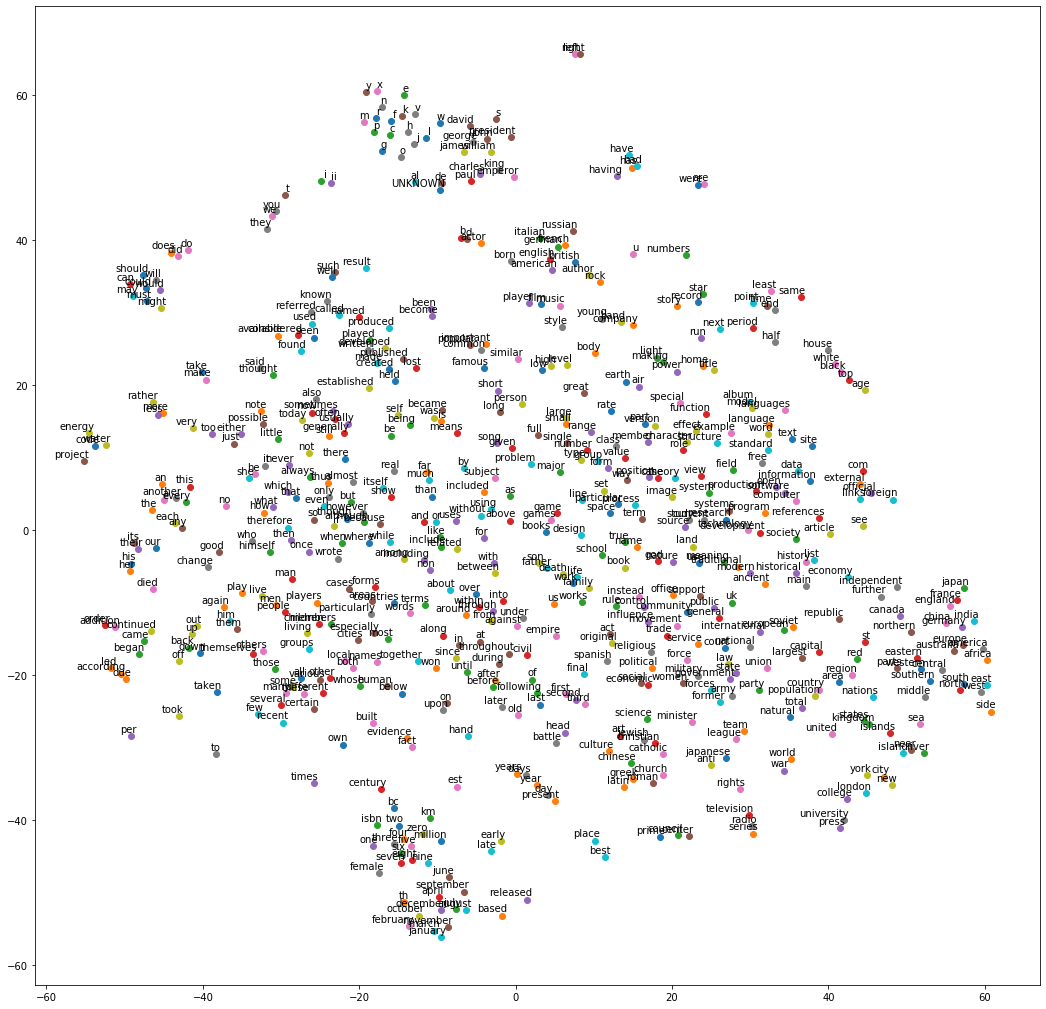

In [42]:
plot_with_labels(low_dim_embs, labels)